In [1]:
import config

import logging
import numpy as np
import pandas as pd

logger = logging.getLogger(__name__)

2023-10-03 08:34:51,020 - INFO     | config     | Loading environment variables


In [2]:
import glob
import pickle
import re

files = glob.glob('embeddings/*_test.pkl')
embeddings_data = {}

for file in files:
    logger.info(f'Loading {file}')
    match_obj = re.search(r'/(?P<output>[^_/]+)_', file)
    filename = match_obj.group('output')
    with open(file, 'rb') as fp:
        dict = pickle.load(fp)
        embeddings_data[filename] = dict

2023-05-30 17:45:18,906 - INFO     | __main__   | Loading embeddings/glove_embeddings_test.pkl
2023-05-30 17:45:18,909 - INFO     | __main__   | Loading embeddings/mpnet_embeddings_test.pkl
2023-05-30 17:45:18,911 - INFO     | __main__   | Loading embeddings/distil_embeddings_test.pkl
2023-05-30 17:45:18,914 - INFO     | __main__   | Loading embeddings/wiki_embeddings_test.pkl
2023-05-30 17:45:18,916 - INFO     | __main__   | Loading embeddings/w2v_embeddings_test.pkl


# Clustering with PCA

In [4]:
from helpers.clustering_helpers import dbscan_loop, kmeans_loop

In [4]:
%%time
dbscan_overall_results = {}
for embeddings_model, embeddings_list in embeddings_data.items():
    logger.info(f'{embeddings_model.upper()}')
    for llm, embeddings in embeddings_list.items():
        logger.info(f'---{llm.upper()}')
        score, components, samples = dbscan_loop(data=embeddings,
                                                 n_components_space=[2, 4, 8, 16, 32, 64, 100],
                                                 min_samples_space = [5, 10, 15, 20])
        
        dbscan_overall_results[(embeddings_model, llm, str(components), str(samples))] = score

2023-05-30 17:45:19,537 - INFO     | __main__   | GLOVE
2023-05-30 17:45:19,538 - INFO     | __main__   | ---BLOOM
2023-05-30 17:45:21,253 - INFO     | __main__   | ---ALPACA_3B
2023-05-30 17:45:21,799 - INFO     | __main__   | ---ALPACA_770M
2023-05-30 17:45:22,031 - INFO     | __main__   | ---LLAMA_13B
2023-05-30 17:45:22,272 - INFO     | __main__   | ---GPT4ALL
2023-05-30 17:45:22,524 - INFO     | __main__   | ---LLAMA_7B
2023-05-30 17:45:23,883 - INFO     | __main__   | MPNET
2023-05-30 17:45:23,884 - INFO     | __main__   | ---BLOOM
2023-05-30 17:45:28,904 - INFO     | __main__   | ---ALPACA_3B
2023-05-30 17:45:33,868 - INFO     | __main__   | ---ALPACA_770M
2023-05-30 17:45:38,687 - INFO     | __main__   | ---LLAMA_13B
2023-05-30 17:45:42,755 - INFO     | __main__   | ---GPT4ALL
2023-05-30 17:45:46,985 - INFO     | __main__   | ---LLAMA_7B
2023-05-30 17:45:51,654 - INFO     | __main__   | DISTIL
2023-05-30 17:45:51,655 - INFO     | __main__   | ---BLOOM
2023-05-30 17:45:55,820 - 

CPU times: user 7min 28s, sys: 2min 15s, total: 9min 44s
Wall time: 1min 15s


In [8]:
%%time
kmeans_overall_results = {}
for embeddings_model, embeddings_list in embeddings_data.items():
    logger.info(f'{embeddings_model.upper()}')
    for llm, embeddings in embeddings_list.items():
        logger.info(f'---{llm.upper()}')
        score, components, iters, n_cluster, tols = kmeans_loop(data=embeddings,
                                                                n_components_space=[2, 4, 8, 16, 32, 64, 100],
                                                                n_clusters_space = [2, 3, 4, 5],
                                                                max_iter_space = [100, 250, 500],
                                                                tol_space = [1e-4, 1e-3, 1e-2, 1e-2]
        kmeans_overall_results[(embeddings_model, llm, str(components), str(iters), str(n_cluster), str(tols))] = score

2023-05-30 17:52:37,430 - INFO     | __main__   | GLOVE
2023-05-30 17:52:37,434 - INFO     | __main__   | ---BLOOM
2023-05-30 17:52:50,181 - INFO     | __main__   | ---ALPACA_3B
2023-05-30 17:53:06,176 - INFO     | __main__   | ---ALPACA_770M
2023-05-30 17:53:19,649 - INFO     | __main__   | ---LLAMA_13B
2023-05-30 17:53:34,335 - INFO     | __main__   | ---GPT4ALL
2023-05-30 17:53:41,421 - INFO     | __main__   | ---LLAMA_7B
2023-05-30 17:53:55,922 - INFO     | __main__   | MPNET
2023-05-30 17:53:55,923 - INFO     | __main__   | ---BLOOM
2023-05-30 17:54:32,120 - INFO     | __main__   | ---ALPACA_3B
2023-05-30 17:55:06,694 - INFO     | __main__   | ---ALPACA_770M
2023-05-30 17:55:43,173 - INFO     | __main__   | ---LLAMA_13B
2023-05-30 17:56:16,264 - INFO     | __main__   | ---GPT4ALL
2023-05-30 17:56:48,685 - INFO     | __main__   | ---LLAMA_7B
2023-05-30 17:57:24,198 - INFO     | __main__   | DISTIL
2023-05-30 17:57:24,199 - INFO     | __main__   | ---BLOOM
2023-05-30 17:58:05,188 - 

CPU times: user 1h 17min 57s, sys: 12min 21s, total: 1h 30min 18s
Wall time: 11min 39s


In [9]:
dbscan_df = pd.DataFrame.from_dict(dbscan_overall_results, orient='index', columns=['Score'])
dbscan_df.index = pd.MultiIndex.from_tuples(dbscan_df.index, names=['EmbeddingsModel', 'LLM', 'PCA', 'MIN_SAMPLES'])

# Display the DataFrame
display(dbscan_df)

Score
EmbeddingsModel LLM         PCA MIN_SAMPLES          
glove           bloom       16  5            0.705346
                alpaca_3b   16  5           -0.095829
                alpaca_770m 16  5                -inf
                llama_13b   16  5                -inf
                gpt4all     16  5                -inf
                llama_7b    16  5            0.252066
mpnet           bloom       16  5            0.752365
                alpaca_3b   16  5            0.353684
                alpaca_770m 16  5            0.272236
                llama_13b   16  5            0.305975
                gpt4all     16  5            0.322380
                llama_7b    16  5            0.365544
distil          bloom       32  15           0.711649
                alpaca_3b   16  5            0.279281
                alpaca_770m 16  20           0.227626
                llama_13b   16  5            0.211128
                gpt4all     16  5            0.226327
                llama_7b    16  5            0.372967
wiki            bloom       16  5            0.716908
                alpaca_3b   16  5           -0.096226
                alpaca_770m 16  5                -inf
                llama_13b   16  5                -inf
                gpt4all     16  5                -inf
                llama_7b    16  5            0.254866
w2v             bloom       32  10           0.742011
                alpaca_3b   16  5            0.218870
                alpaca_770m 16  5            0.264345
                llama_13b   16  5            0.312116
                gpt4all     16  5            0.392577
                llama_7b    16  5            0.439634

In [10]:
kmeans_df = pd.DataFrame.from_dict(kmeans_overall_results, orient='index', columns=['Score'])
kmeans_df.index = pd.MultiIndex.from_tuples(kmeans_df.index, names=['EmbeddingsModel',
                                                                    'LLM',
                                                                    'PCA',
                                                                    'MAX_ITERS',
                                                                    'CLUSTERS',
                                                                    'TOL'])

# Display the DataFrame
display(kmeans_df)

Score
EmbeddingsModel LLM         PCA MAX_ITERS CLUSTERS TOL                           
glove           bloom       16  100       3        0.0001                0.757382
                alpaca_3b   16  100       2        0.0001                0.144175
                alpaca_770m 64  100       2        0.0001                0.463143
                llama_13b   64  100       2        0.0001                0.131586
                gpt4all     32  100       2        0.0001                0.130505
                llama_7b    16  100       2        0.0001                0.362397
mpnet           bloom       16  100       2        0.0001                0.779275
                alpaca_3b   16  100       2        0.0001                0.206025
                alpaca_770m 32  100       3        0.005050000000000001  0.170061
                llama_13b   64  100       3        0.0001                0.115189
                gpt4all     64  100       2        0.0001                0.489066
                llama_7b    16  100       2        0.0001                0.357098
distil          bloom       32  100       4        0.0001                0.737272
                alpaca_3b   64  100       2        0.0001                0.098994
                alpaca_770m 64  100       3        0.0001                0.149407
                llama_13b   32  100       2        0.0001                0.087967
                gpt4all     32  100       3        0.007525000000000001  0.182673
                llama_7b    16  100       2        0.0001                0.362837
wiki            bloom       16  100       3        0.0001                0.756013
                alpaca_3b   16  100       2        0.0001                0.150221
                alpaca_770m 64  100       2        0.0001                0.162413
                llama_13b   64  100       2        0.0001                0.142147
                gpt4all     16  100       2        0.0001                0.119297
                llama_7b    16  100       2        0.0001                0.449177
w2v             bloom       16  100       3        0.0001                0.749174
                alpaca_3b   16  100       3        0.0001                0.135286
                alpaca_770m 16  100       2        0.0001                0.124184
                llama_13b   32  100       2        0.0001                0.121197
                gpt4all     16  100       2        0.0001                0.096535
                llama_7b    16  100       2        0.0001                0.472542

## New Testing

In [1]:
import config

import logging
import numpy as np
import pandas as pd


logger = logging.getLogger(__name__)

2023-10-08 11:13:34,327 - INFO     | config     | Loading environment variables


In [2]:
from models.clustering import ClusteringModel
from helpers.clustering_helpers import dbscan_loop, kmeans_loop, get_best_scores

import pickle
with open(f'embeddings/2000T_embeddings_202375.pkl', 'rb') as f:
        embeddings_dict = pickle.load(f)

df = pd.read_parquet('full_data_202375.parquet')
df_new = df.drop(columns=['gpt-3.5-turbo_kmeans',
                          'alpaca_kmeans',
                          'gpt4all_kmeans',
                          'gpt-3.5-turbo_dbscan',
                          'alpaca_dbscan'])

# KMeans

In [3]:
# kmeans

best_results_kmeans = {}
for llm, embeddings in embeddings_dict.items():
    logger.info(f'{llm.upper()}')
    results = kmeans_loop(data=embeddings,
                          n_components_space=[None, 0.70, 0.80, 0.90, 0.95, 0.99],
                          n_clusters_space = list(np.linspace(1, 10, 10, dtype='int')),
                          max_iter_space = [250, 500])
    
    best_results_kmeans[llm] = get_best_scores(results=results, model_name='kmeans')
    best_results_kmeans[llm]['original_emb'] = embeddings

2023-10-08 11:13:36,556 - INFO     | __main__   | GPT-3.5-TURBO
2023-10-08 11:15:53,011 - INFO     | helpers.clustering_helpers | Best Score: 0.11989984661340714
2023-10-08 11:15:53,013 - INFO     | __main__   | ALPACA
2023-10-08 11:17:44,042 - INFO     | helpers.clustering_helpers | Best Score: 0.11407428234815598
2023-10-08 11:17:44,061 - INFO     | __main__   | GPT4ALL
2023-10-08 11:19:32,483 - INFO     | helpers.clustering_helpers | Best Score: 0.15536846220493317


In [4]:
pd.DataFrame.from_dict(best_results_kmeans, orient='index')

,score,n_components,actual_components,max_iter,n_clusters,original_emb
gpt-3.5-turbo,0.119900,0.90,142,250,2,"[[-0.03887094, -0.11050342, -0.031814046, 0.02..."
alpaca,0.114074,0.99,375,250,3,"[[0.011134546, -0.08676946, -0.03891137, 0.060..."
gpt4all,0.155368,NaN,768,250,2,"[[-0.02282622, -0.08779901, -0.021268817, -0.0..."


In [5]:
final_kmeans_emb = {}
kmeans_pca_data = {}
kmeans_clusters = []
for llm, params in best_results_kmeans.items():
    logger.info(llm.upper())
    kmeans = ClusteringModel(model_name='kmeans',
                             n_init='auto',
                             max_iter=params['max_iter'],
                             n_clusters=params['n_clusters'])
    kmeans.fit_predict(embeddings=params['original_emb'],
                       pca_flag=True,
                       n_components=params['n_components'])
    kmeans_clusters.append(kmeans.clusters)
    
    final_kmeans_emb[llm] = (params['original_emb'], kmeans.embeddings)
    kmeans_pca_data[llm] = (kmeans.pca.explained_variance_ratio_, kmeans.pca.explained_variance_ratio_.cumsum())

2023-10-08 11:19:32,698 - INFO     | __main__   | GPT-3.5-TURBO
2023-10-08 11:19:33,259 - INFO     | __main__   | ALPACA
2023-10-08 11:19:34,164 - INFO     | __main__   | GPT4ALL


In [6]:
df_new['gpt-3.5-turbo_kmeans'] = kmeans_clusters[0]
df_new['alpaca_kmeans'] = kmeans_clusters[1]
df_new['gpt4all_kmeans'] = kmeans_clusters[2]

# DBSCAN

In [7]:
# dbscan

best_results_dbscan = {}
for llm, embeddings in embeddings_dict.items():
    logger.info(f'{llm.upper()}')
    results = dbscan_loop(data=embeddings,
                          n_components_space=[None, 0.70, 0.80, 0.90, 0.95, 0.99],
                          eps_space= [0.5, 0.6, 0.7, 0.8, 0.9],
                          min_samples_space=[5, 25, 50, 75, 100, 200, 300, 400, 500])
    
    best_results_dbscan[llm] = get_best_scores(results=results, model_name='dbscan')
    best_results_dbscan[llm]['original_emb'] = embeddings

2023-10-08 11:19:34,976 - INFO     | __main__   | GPT-3.5-TURBO
2023-10-08 11:19:35,807 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 11:21:38,539 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 11:22:24,556 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 11:23:08,323 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 11:23:51,395 - INFO     | helpers.clustering_helpers | Best Score: 0.09637953341007233
2023-10-08 11:23:51,397 - INFO     | __main__   | ALPACA
2023-10-08 11:23:53,066 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 11:23:54,121 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 11:25:19,395 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 11:26:01,661 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 11:26:41,586 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 11:26:42,437 - INFO     | helpers.clustering_helpers | Found them
2023-10-08 

In [8]:
pd.DataFrame.from_dict(best_results_dbscan, orient='index')

,score,n_components,actual_components,min_samples,eps,n_clusters,original_emb
gpt-3.5-turbo,0.096380,0.90,142.0,5.0,0.5,3.0,"[[-0.03887094, -0.11050342, -0.031814046, 0.02..."
alpaca,0.149651,0.95,203.0,5.0,0.6,3.0,"[[0.011134546, -0.08676946, -0.03891137, 0.060..."
gpt4all,NaN,NaN,NaN,NaN,NaN,NaN,"[[-0.02282622, -0.08779901, -0.021268817, -0.0..."


In [9]:
final_dbscan_emb = {}
dbscan_pca_data = {}
dbscan_clusters = []
for llm, params in best_results_dbscan.items():
    logger.info(llm.upper())
    try:
        dbscan = ClusteringModel(model_name='dbscan',
                                 eps=params['eps'],
                                 min_samples=params['min_samples'],
                                 metric='euclidean')
        dbscan.fit_predict(embeddings=params['original_emb'],
                           pca_flag=True,
                           n_components=params['n_components'])
        dbscan_clusters.append(dbscan.clusters)
        
        final_dbscan_emb[llm] = (params['original_emb'], dbscan.embeddings)
        dbscan_pca_data[llm] = (dbscan.pca.explained_variance_ratio_,dbscan.pca.explained_variance_ratio_.cumsum())
        
    except Exception as e:
        logger.warning(f'Not Clusters Found for {llm.upper()}')

2023-10-08 11:31:56,803 - INFO     | __main__   | GPT-3.5-TURBO
2023-10-08 11:31:57,291 - INFO     | __main__   | ALPACA
2023-10-08 11:31:57,798 - INFO     | __main__   | GPT4ALL
2023-10-08 11:31:57,798 - WARNING  | __main__   | Not Clusters Found for GPT4ALL


In [10]:
df_new['gpt-3.5-turbo_dbscan'] = dbscan_clusters[0]
df_new['alpaca_dbscan'] = dbscan_clusters[1]

# Analysis

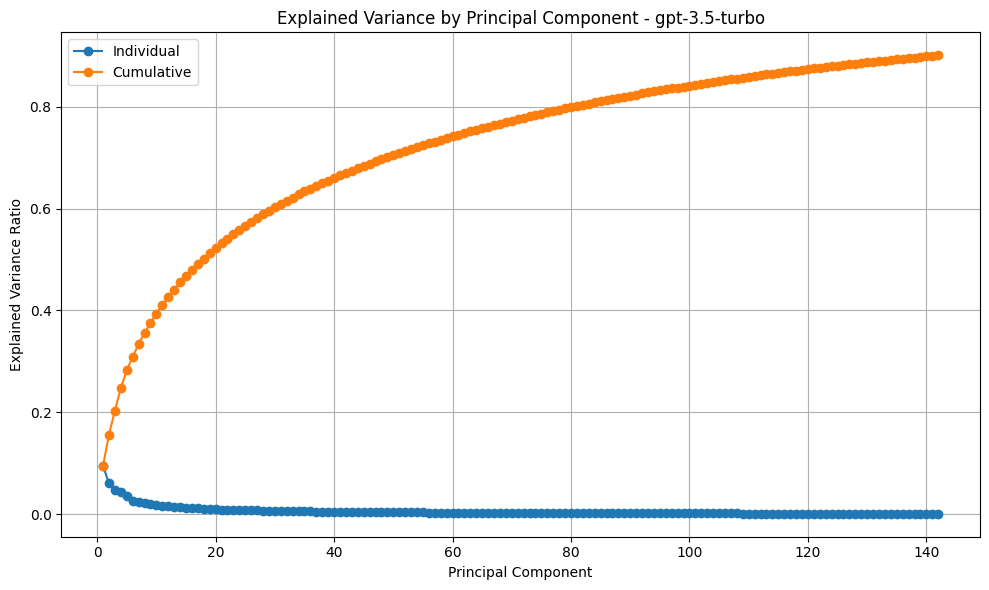

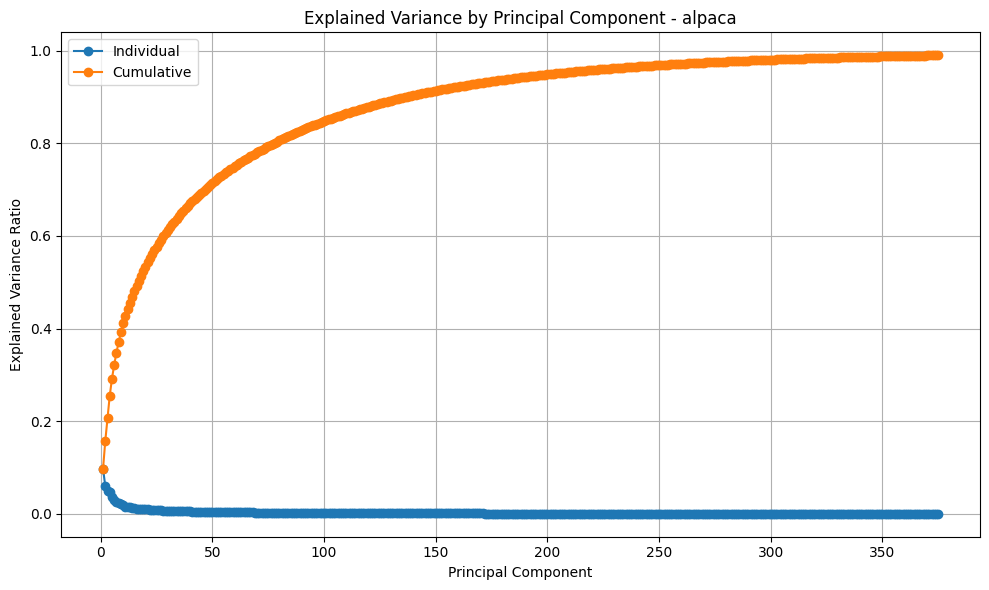

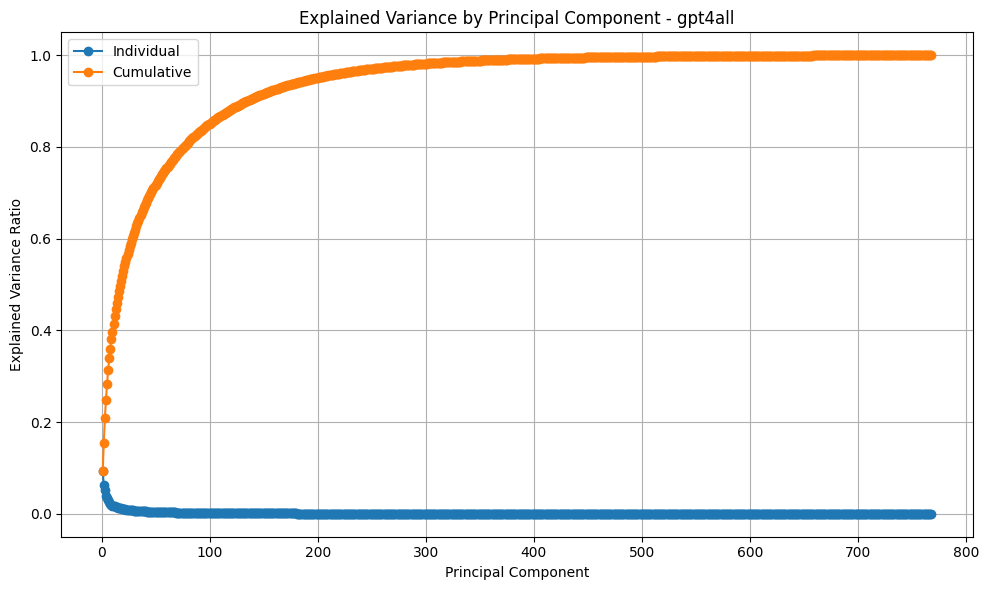

In [23]:
import matplotlib.pyplot as plt

for llm, embs in kmeans_pca_data.items():

    # Simple Line Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(embs[0])+1), embs[0], label='Individual', marker='o')
    plt.plot(range(1, len(embs[0])+1), embs[1], label='Cumulative', marker='o')
    plt.title(f'Explained Variance by Principal Component - {llm}')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'fig/{llm}_var_exp.png', dpi=300)

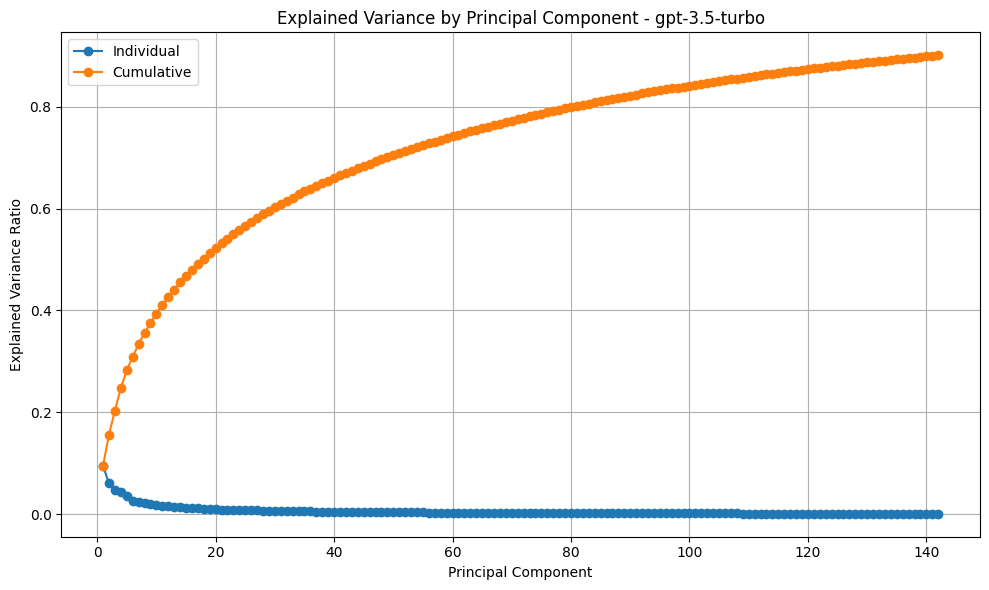

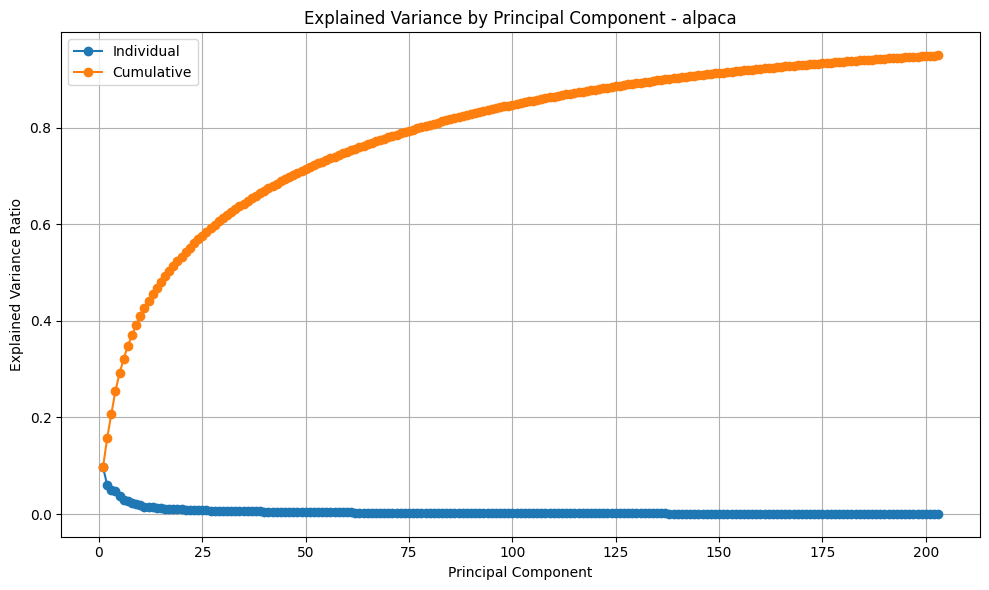

In [24]:
for llm, embs in dbscan_pca_data.items():

    # Simple Line Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(embs[0])+1), embs[0], label='Individual', marker='o')
    plt.plot(range(1, len(embs[0])+1), embs[1], label='Cumulative', marker='o')
    plt.title(f'Explained Variance by Principal Component - {llm}')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [30]:
df_new[['full_text', 'gpt-3.5-turbo', 'gpt-3.5-turbo_kmeans']].loc[df['gpt-3.5-turbo_kmeans'] == 0].to_excel('fig/C0_gpt-3.5-turbo.xlsx', index=True)

In [19]:
df_new.head()

,id,full_text,gpt-3.5-turbo,alpaca,gpt4all,gpt-3.5-turbo_embeddings,alpaca_embeddings,gpt4all_embeddings,gpt-3.5-turbo_kmeans,alpaca_kmeans,gpt4all_kmeans,gpt-3.5-turbo_dbscan,alpaca_dbscan
0,1641514595339862016,thus continuing the roberts' (boebert's maide...,"No, this tweet is not a potential lead. The co...","Yes, this tweet is a potential lead because it...",\nThe given tweet is not a potential lead as i...,"[-0.03887094184756279, -0.1105034202337265, -0...","[0.011134546250104904, -0.0867694616317749, -0...","[-0.022826220840215683, -0.08779901266098022, ...",1,0,1,0,-1
1,1642044261649780736,my green &amp; black reputation eyeshadow look,No. The tweet does not provide any indication ...,"Yes, the tweet is a potential lead because it ...","\nNo, the above tweet is not a potential lead ...","[-0.024825602769851685, -0.10440673679113388, ...","[-0.022449074313044548, -0.08849964290857315, ...","[-0.02361299842596054, -0.1094249039888382, -0...",1,2,0,0,0
2,1642124227590467584,i don't either but i put an eye liner for sha...,"No, the above tweet is not a potential lead. A...","Yes, the tweet is a potential lead because it ...",\nThe given tweet is not a potential lead as i...,"[-0.022488590329885483, -0.09907253086566925, ...","[-0.021942151710391045, -0.09090302884578705, ...","[0.007977220229804516, -0.06419841200113297, -...",1,2,1,0,0
3,1642307728654888961,join the marketsource team! see our latest job...,"Yes, the above tweet is a potential lead. The ...","Yes, the tweet is a potential lead because it ...",\nThe given tweet is not a potential lead as i...,"[-0.0332973413169384, -0.09525896608829498, -0...","[-0.048098124563694, -0.09722025692462921, -0....","[-0.017496967688202858, -0.0763673409819603, -...",0,2,1,0,0
4,1642521653497217025,check out mini oneida ceramic floral cherry te...,"No, the above tweet is not a potential lead. T...","Yes, the tweet is a potential lead because it ...","\nNo, the given tweet is not a potential lead....","[-0.017981532961130142, -0.08915165811777115, ...","[-0.007265061605721712, -0.09268850088119507, ...","[-0.010253571905195713, -0.08222711831331253, ...",1,0,0,0,0


In [33]:
from helpers.data_viz import plot_clusters_2D

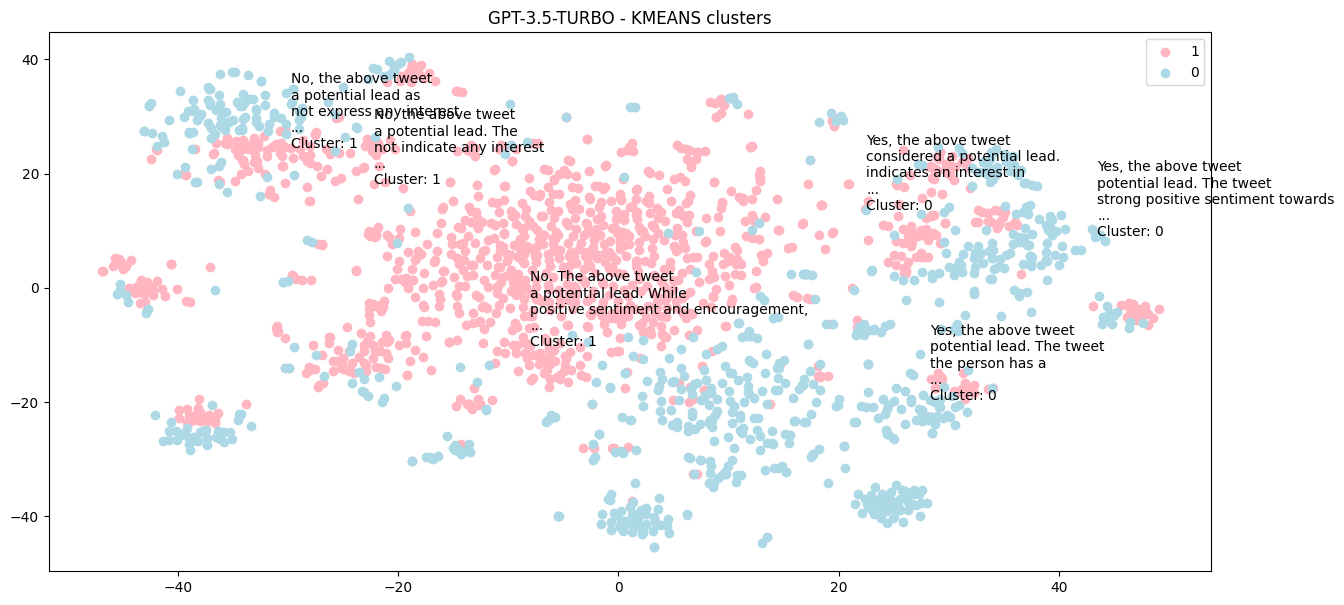

In [43]:
plot_clusters_2D(df=df_new,
                 llm='gpt-3.5-turbo',
                 cluster_algo='kmeans',
                 text_col='output',
                 n=6,
                 save_fig=True,
                 fig_name='comp_0-1-turbo-output',
                 indices=[41, 
                          91,
                          1825,
                          57,
                          812,
                          1892],
                 manual=True)

/Users/lorenzo/Documents/repos/msc-thesis-llm-clustering/helpers/data_viz.py:71: UserWarning: Glyph 128139 (\N{KISS MARK}) missing from current font.
  plt.savefig(f'fig/{llm}_{cluster_algo}_{fig_name}.png', dpi=300)  # Save with a high DPI value
/Users/lorenzo/.pyenv/versions/3.9.13/envs/thesis/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128139 (\N{KISS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


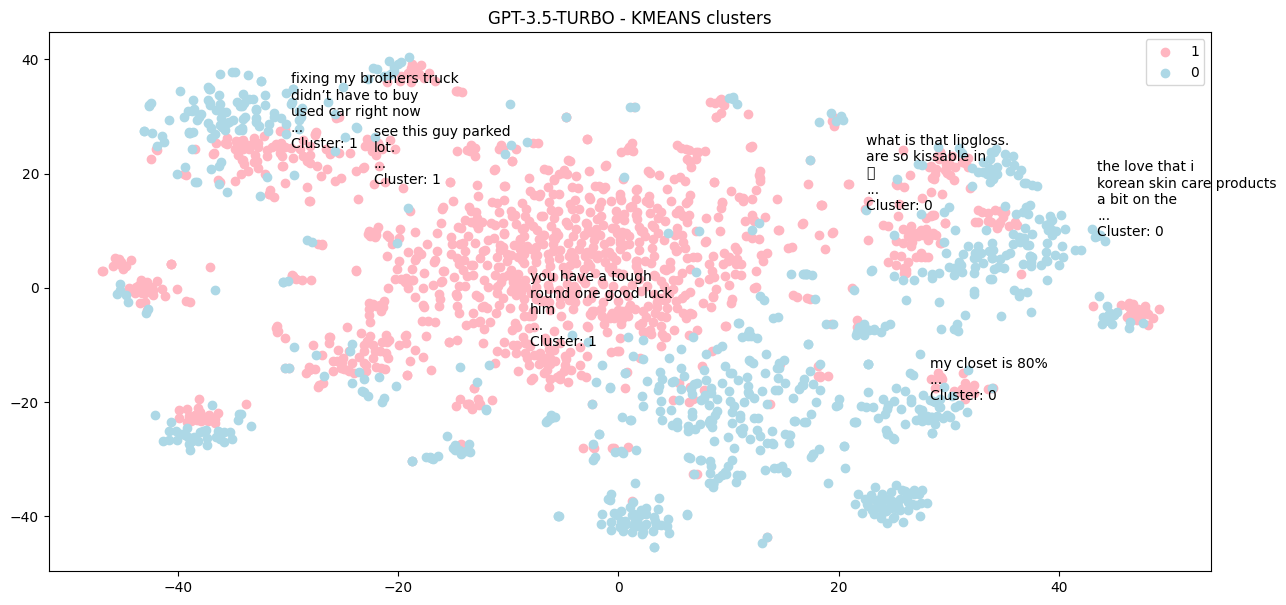

In [44]:
plot_clusters_2D(df=df_new,
                 llm='gpt-3.5-turbo',
                 cluster_algo='kmeans',
                 text_col='tweet',
                 n=6,
                 save_fig=True,
                 fig_name='comp_0-1-turbo-tweet',
                 indices=[41, 
                          91,
                          1825,
                          57,
                          812,
                          1892],
                 manual=True)